<a href="https://colab.research.google.com/github/comet-toolkit/comet_training/blob/main/LPS_training_exercise2_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LPS Hands-on Training Session - CoMet Toolkit: Uncertainties made easy**

#Exercise 2: Multi-Dimension Datasets

## Objectives

In this exercise we will cover:

* How to use [**obsarray**](https://obsarray.readthedocs.io/en/latest/) to store error-correlation information for multi-dimensional measurement datasets - such as from Earth Observation.
* Propagating uncertainties from these datasets through measurement functions using [**punpy**](https://punpy.readthedocs.io/en/latest/).

## *Step 1* - Environment Setup

As in Exercise 1, we start by collecting test data and installing and importing the required CoMet Toolkit packages --- [**obsarray**](https://obsarray.readthedocs.io/en/latest/) and [**punpy**](https://punpy.readthedocs.io/en/latest/).

In [4]:
# Clone the CoMet Training repository to access training data
!git clone https://github.com/comet-toolkit/comet_training.git

Cloning into 'comet_training'...
remote: Enumerating objects: 412, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 412 (delta 13), reused 9 (delta 4), pack-reused 388 (from 1)
Receiving objects: 100% (412/412), 4.73 MiB | 23.04 MiB/s, done.
Resolving deltas: 100% (279/279), done.


In [1]:
# Install CoMet Toolkit packages
!pip install obsarray>=1.0.1
!pip install punpy>=1.0.5

In [11]:
# Import packages
import obsarray
import punpy
import xarray as xr
import numpy as np
import warnings
warnings.filterwarnings('ignore') # hide any confusing warnings!

CoMet Toolkit's [**obsarray**](https://obsarray.readthedocs.io/en/latest/) package is an extension to the popular [xarray](https://docs.xarray.dev/en/stable/) package.

[`xarray.Dataset`](https://docs.xarray.dev/en/stable/user-guide/data-structures.html#dataset)'s are objects in python that represent the data model of the [netCDF file format](https://www.unidata.ucar.edu/software/netcdf/). **obsarray** allows you to assign uncertainties to variables in xarray Datasets, with their associated error-correlation.

This is achieved by using the CoMet Toolkit's draft [UNC Specification](https://comet-toolkit.github.io/unc_website/) metadata standard for dataset variable attributes. So such objects are portable, and can be stored to and from netCDF files on disc.


## *Step 2* - Interfacing with a Measurement Dataset using **obsarray**

In this step of the exercise, we will explore how to define and interact with the *uncertainty variables* (i.e., uncertainty components) associated with *observation variables* in measurement datasets using **obsarray**.

Our example will be a multi-spectral dataset of Level 1 (L1) [Brightness Temperatures](https://en.wikipedia.org/wiki/Brightness_temperature) (BT) from the AVHRR sensor on MetOp-A. This [dataset](https://catalogue.ceda.ac.uk/uuid/14a8098d70714cc1bf38f9dbcb82e5ed/) was created as part of the [FIDUCEO](https://research.reading.ac.uk/fiduceo/) project.

Here we open an extract contained in a [netCDF](https://www.unidata.ucar.edu/software/netcdf/) file, which has an observation variable -- `bt` -- with the following dimensions:

* $y$, along track -- 100 pixels at 1 km resolution
* $x$, across track -- 100 pixels at 1 km resolution
* $band$, spectral bands -- 2 thermal infrared (TIR) bands, called Channel 4 and 5, centred on $\sim$11 μm and 12 μm


<xarray.Dataset> Size: 320kB
Dimensions:    (band: 2, y: 100, x: 100)
Coordinates:
  * band       (band) int64 16B 4 5
    latitude   (y, x) float64 80kB ...
    longitude  (y, x) float64 80kB ...
Dimensions without coordinates: y, x
Data variables:
    bt         (band, y, x) float64 160kB ...


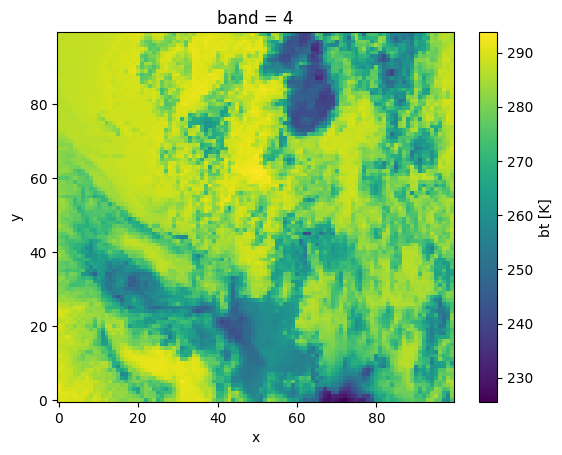

In [5]:
# open xarray.Dataset from netCDF file
dataset_path = "comet_training/avhrr_ds.nc"
avhrr_ds = xr.open_dataset(dataset_path)

# inspect dataset
print(avhrr_ds)
avhrr_ds["bt"][0].plot()

After import, **obsarray** functionality is accessed throught the `unc` "[accessor](https://docs.xarray.dev/en/stable/internals/extending-xarray.html)" -- which looks like a new method that becomes available on xarray Datasets.

We can use this to [assign an *uncertainty variable*](https://obsarray.readthedocs.io/en/latest/content/user/unc_accessor.html#adding-removing-uncertainty-components) to the `bt` variable, in a very similar way to adding a normal variable to an xarray Dataset:

In [6]:
# define u_noise values - set as 1%
u_noise_values = avhrr_ds["bt"].values * 0.01

# add an uncertainty component associated with noise error to the brightness temperature
avhrr_ds.unc["bt"]["u_bt_noise"] = (["band", "y", "x"], u_noise_values, {"units": "K"})

In [7]:
# inspect ds variables
print(avhrr_ds)

<xarray.Dataset> Size: 480kB
Dimensions:     (band: 2, y: 100, x: 100)
Coordinates:
  * band        (band) int64 16B 4 5
    latitude    (y, x) float64 80kB ...
    longitude   (y, x) float64 80kB ...
Dimensions without coordinates: y, x
Data variables:
    bt          (band, y, x) float64 160kB 289.4 290.4 290.2 ... 286.5 284.7
    u_bt_noise  (band, y, x) float64 160kB 2.894 2.904 2.902 ... 2.865 2.847


Uncertainty variables have an assocaited error-correlation structure -- since we didn't define this for `u_noise`, it is assumed to be random (i.e., errors are uncorrelated between pixels).

Next let's add a calibration uncertainty component, `u_bt_cal`, with a more complicated error-correlation structure using the `err_corr` attribute. This uses the [error-correlation parameterisations](https://comet-toolkit.github.io/unc_website/specification/draft-v0.1/unc_specification.html#appendix-a-error-correlation-parameterisations) defined by the draft UNC Specfication (it is also possible to add custom error-correlation parameterisations).

Let's set the pixel errors associated with `u_bt_cal` to be systematic (i.e., the same/common) in the `x` and `y` dimension and defined by a custom matrix in the `band` dimension.

In [8]:
# create cross-channel error-correlation matrix
chl_err_corr_matrix = np.array([[1.0, 0.7],[0.7, 1.0]])
avhrr_ds["chl_err_corr_matrix"] = (("band1", "band2"), chl_err_corr_matrix)

# use this to define error-correlation parameterisation attribute
err_corr_def = [
    # fully systematic in the x and y dimension
    {
        "dim": ["y", "x"],
        "form": "systematic",
        "params": [],
        "units": []
    },
    # defined by err-corr matrix var in band dimension
    {
        "dim": ["band"],
        "form": "err_corr_matrix",
        "params": ["chl_err_corr_matrix"],  # defines link to err-corr matrix var
        "units": []
    }
]

# define u_cal values - set as 5%
u_cal_values = avhrr_ds["bt"].values * 0.05

# add an uncertainty component associated with calibration error to the brightness temperature
avhrr_ds.unc["bt"]["u_bt_cal"] = (
    ["band", "y", "x"],
    u_cal_values,
    {"err_corr": err_corr_def, "units": "K"}
)

We can now interface with this information using the `unc` accessor,

In [9]:
avhrr_ds.unc["bt"]

<VariableUncertainty>
Variable Uncertainties: 'bt'
Data variables:
    u_bt_noise  (band, y, x) float64 160kB 2.894 2.904 2.902 ... 2.865 2.847
    u_bt_cal    (band, y, x) float64 160kB 14.47 14.52 14.51 ... 14.33 14.23

For example, we can use it to evaluate information about the dataset combined error-covariance,

In [10]:
# Evaluate total uncertainty for bands at pixel (0,0)
u_tot = avhrr_ds.unc["bt"][:,0,0].total_unc()
print("Total Uncertainty per Band:")
print(u_tot.values)

# Evaluate combined band-to-band err-corr matrix for pixel (0,0)
err_corr_tot = avhrr_ds.unc["bt"][:,0,0].total_err_corr_matrix()
print("\nTotal Error Correlation between Bands:")
print(err_corr_tot.values)

Total Uncertainty per Band:
[14.75503277 14.71679012]

Total Error Correlation between Bands:
[[1.         0.67307692]
 [0.67307692 1.        ]]


# *Step 3* - Uncertainty Propagation

Thermal Infrared multi-spectral data, like our example AVHRR dataset, is used to develop Level 2 (L2) Climate Data Records (CDRs) such as Sea or Land Surface Temperature (SST or LST). SST/LST retriavals account for the atmosphere to evaluate the surface temperature from the top of atmosphere L1 brightness temperature.

A widely approach for this is called the "split window" method. A simplified form of this algorithm could be represented as,

$SST = a T_{11} - b T_{12}$

where:

* $T_{11}$​ is the brightness temperature in the 11 μm band
* $T_{12}$​ is the brightness temperature in the 12 μm band
* $a$ & $b$ are empirically derived retrieval coefficients

For the purpose of the exercise, set $a=2$ and $b=1$.

## **Exercise**

Using what we learned in [Exercise 1](https://colab.research.google.com/github/comet-toolkit/comet_training/blob/main/LPS_training_exercise1.ipynb), create a measurement function to apply the SST retrieval to our AVHRR dataset and propagate the uncertainties using **punpy**.

In [28]:
# define SST measurement function
def meas_function(bt11: np.ndarray, bt12: np.ndarray) -> np.ndarray:
    """
    Returns SST from input L1 BTs using split window method

    :param bt11: brightness temperature 11 um band
    :param bt12: brightness temperature 11 um band
    :returns: evaluated SST
    """

    # set parameter values
    a = 2
    b = 1

    # evaluate SST
    sst = a * bt11 - b * bt12

    return sst


# initialise a punpy MCpropagation object with 10000 MC samples
prop=punpy.MCPropagation(1000)

# apply the measurement function to calculate SST
sst = meas_function(avhrr_ds["bt"][0,:,:], avhrr_ds["bt"][1,:,:])

# propagate random uncertainties
u_sst_noise = prop.propagate_random(
    meas_function,
    [avhrr_ds["bt"][0,:,:].values, avhrr_ds["bt"][1,:,:].values],
    [avhrr_ds["u_bt_noise"][0,:,:].values, avhrr_ds["u_bt_noise"][1,:,:].values]
)

# propagate systematic uncertainties
u_sst_cal = prop.propagate_systematic(
    meas_function,
    [avhrr_ds["bt"][0,:,:].values, avhrr_ds["bt"][1,:,:].values],
    [avhrr_ds["u_bt_cal"][0,:,:].values, avhrr_ds["u_bt_cal"][1,:,:].values],
    corr_between=avhrr_ds["chl_err_corr_matrix"].values
)

# assign to obsarray
sst = xr.Dataset({"sst": (["y", "x"], sst.values, {"units": "K"})})

sst.unc["sst"]["u_sst_noise"] = (
    ["y", "x"],
    u_sst_noise,
    {"units": "K"}
)
sst.unc["sst"]["u_sst_cal"] = (
    ["y", "x"],
    u_sst_cal,
    {
        "err_corr": [{"dim": ["y", "x"], "form": "systematic"}],
        "units": "K"
    }
)

<xarray.Dataset> Size: 240kB
Dimensions:      (y: 100, x: 100)
Dimensions without coordinates: y, x
Data variables:
    sst          (y, x) float64 80kB 290.1 290.9 290.8 ... 286.9 288.0 286.3
    u_sst_noise  (y, x) float64 80kB 6.388 6.547 6.232 ... 6.088 6.583 6.477
    u_sst_cal    (y, x) float64 80kB 20.01 20.08 20.07 ... 19.79 19.86 19.74


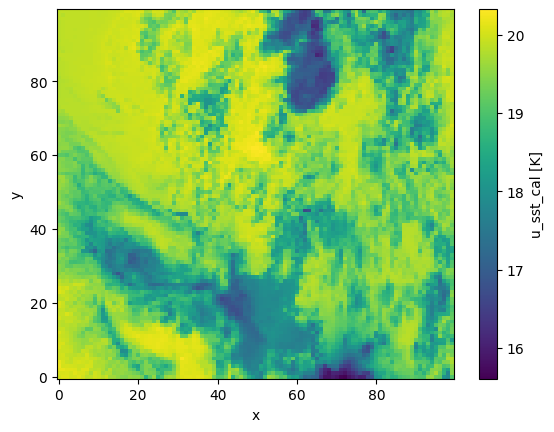

In [30]:
print(sst)
sst["u_sst_cal"].plot()

# *Extension* - Propagating Dataset Uncertainties with the `MeasurementFunction` Class

**punpy**'s [`MeasurementFunction`](https://punpy.readthedocs.io/en/latest/content/punpy_digital_effects_table.html#measurement-function) class enables a much simpler method for propagating the uncertainties of measurement datasets defined using **obsarray**. It is an alternative interface to the **punpy** propagation functions we used in Step 3.

For this approach instead defining the measurement function as a python function, we define a measurement function class which should be a subclass of the **punpy** `MeasurementFunction` class. We can then use the class's [`propagate_ds`](https://punpy.readthedocs.io/en/latest/content/punpy_digital_effects_table.html#functions-for-propagating-uncertainties) method to propagate all dataset uncertainties in one go!

In [ ]:
class SplitWindowSST(punpy.MeasurementFunction):
    #
    # define primary method of class - the measurement function
    #
    def meas_function(self, bt: np.ndarray) -> np.ndarray:
        """
        Returns SST from input L1 BTs using split window method

        :param bt: brightness temperature datacube
        :returns: evaluated SST
        """

        # set parameter values
        a = 2
        b = 1

        # evaluate SST
        sst = a * bt[0,:,:] - b * bt[1,:,:]

        return sst

    #
    # define helper methods to configure class
    #
    def get_measurand_name_and_unit(self) -> tuple[str, str]:
        """
        For dataset evaluate by measurement function, returns a tuple of
        measurand variable name and units

        :returns: measurand name, measurand unit name
        """
        return "sst", "K"

    def get_argument_names(self) -> list[str]:
        """
        Returns orders list input dataset variables names associated with
        meas_function arguments

        :returns: input dataset variable names
        """
        return ["bt"]

# create punpy propagation object
prop = punpy.MCPropagation(100, parallel_cores=1)

# Instatiate measurement function object with prop
sst_ret = SplitWindowSST(
    prop=prop,
    ydims=["y", "x"],
    sizes_dict={"y": 100, "x": 100},
)

# run uncertainty propagation
sst_ds = sst_ret.propagate_ds(avhrr_ds, include_corr=False)

TypeError: unhashable type: 'list'

# **Exercise**

Adapt the `MeasurementFunction` class approach above to include error-covariance for the set of parameters $a$ and $b$.

In [ ]:
# Enter your code here

# **Next Exercise...**

In [Exercise 3](https://colab.research.google.com/github/comet-toolkit/comet_training/blob/main/LPS_training_exercise3.ipynb) you will either try to apply these tools to propagate uncertainties for your own usecase, or alternatively try to implement uncertainty propagation for a usecase we have provided.